In [43]:
import numpy as np
import random
from glob import glob

#We're using function from image_recognition to process photos
# from image_recognition import

#This is where the classification and categorization of images will occur
data_dir = 'Dataset'
train = 'Dataset/training'
test = 'Dataset/evaluation'
valid = 'Dataset/validation'
label_names = ['Bread', 'Dairy Product', 'Dessert', 'Egg', 'Fried Food', 'Meat', 'Noodles-Pasta', 'Rice',
               'Seafood', 'Soup', 'Vegetable-Fruit']

training_files = glob('Dataset/training/*/*.jpg')
training_set_size = [50,100, 250, 500, 1000, 5000, 9000]

new_training_set = []


In [44]:
import os
# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

datagen = ImageDataGenerator()
def gen_training_data(size=10):
    total_num_training_images = 9866.
    return keras.utils.image_dataset_from_directory( 
        directory=train, 
        image_size=(224, 224),
        shuffle = True,
        subset = "training",
        validation_split = 1-(size/total_num_training_images),
        batch_size=50, 
        seed = 512365 
    )
# validation data
valid_generator = datagen.flow_from_directory( 
    directory=valid, 
    classes = label_names,
    target_size=(224, 224), 
    batch_size=50, 
    class_mode="binary", 
    shuffle = True
)

    # build the entire model
    # Code taken from 
    # https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/image-classification/tensorflow/resnet50/notebook-resnet-transfer-learning-image-classification.ipynb
    # Created by eleapttn
def model_creation():
    resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
    for layer in resnet_50.layers:
        layer.trainable = False
    x = resnet_50.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(11, activation='softmax')(x)
    return (Model(inputs = resnet_50.input, outputs = predictions))

# define training function
    # Code taken from 
    # https://github.com/ovh/ai-training-examples/blob/main/notebooks/computer-vision/image-classification/tensorflow/resnet50/notebook-resnet-transfer-learning-image-classification.ipynb
    # Created by eleapttn
def trainModel(model, passes, optimizer, training_data):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(training_data, validation_data=valid_generator, epochs=passes, batch_size=batch_size)



Found 2960 images belonging to 11 classes.


In [45]:
import matplotlib.pyplot as plt
def graph_accuracy(sizes, test, val, train):
    plt.plot(sizes, test, color='Blue', label="Test Data")
    plt.plot(sizes, val, color= 'Red', label="Validation Data")
    plt.plot(sizes, train, color='Green', label="Training Data")
    plt.legend(loc="upper left")
    plt.xlabel("Sizes of Training Data")
    plt.title("Size of Training Data vs Accuracy of Model")
    plt.ylabel("Accuracy")
    plt.show()


In [46]:
import scipy
test_data = datagen.flow_from_directory( 
    directory=test, 
    classes = label_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary",
    shuffle=False
)
predict_valid_generator = datagen.flow_from_directory( 
    directory=valid, 
    classes = label_names,
    target_size=(224, 224), 
    batch_size=50, 
    class_mode="binary", 
    shuffle = False
)

def find_accuracy(labels, predictions):
    sum = 0
    for i in range(len(labels)):
        if labels[i]==predictions[i]:
            sum +=1
    return sum/len(labels)


test_class = test_data.labels
valid_class = predict_valid_generator.labels
training_Accuracy = []
validation_Accuracy = []
testing_Accuracy = []
for size in training_set_size:
    print(size)
    training_data = gen_training_data(size)
    model = model_creation()
    model_history = trainModel(model, passes=10, optimizer="Adam", training_data=training_data)
    predictions = model.predict(test_data)
    class_ids = np.argmax(predictions, axis=1)
    testing_Accuracy.append(find_accuracy(test_class, class_ids))
    training_Accuracy.append(model_history)
    predictions = model.predict(predict_valid_generator)
    class_ids = np.argmax(predictions, axis=1)
    validation_Accuracy.append(find_accuracy(valid_class, class_ids))
    print(training_Accuracy)

Found 2912 images belonging to 11 classes.
Found 2960 images belonging to 11 classes.
50
Found 9866 files belonging to 11 classes.
Using 50 files for training.
Epoch 1/10
1/1 [==============================] - 145s 145s/step - loss: 4.6978 - accuracy: 0.1200 - val_loss: 2.4767 - val_accuracy: 0.1351
Epoch 2/10
1/1 [==============================] - 143s 143s/step - loss: 3.5862 - accuracy: 0.1600 - val_loss: 2.4143 - val_accuracy: 0.1233
Epoch 3/10
1/1 [==============================] - 142s 142s/step - loss: 3.9199 - accuracy: 0.0600 - val_loss: 2.3245 - val_accuracy: 0.1399
Epoch 4/10
1/1 [==============================] - 144s 144s/step - loss: 4.0455 - accuracy: 0.0800 - val_loss: 2.2910 - val_accuracy: 0.1500
Epoch 5/10
1/1 [==============================] - 143s 143s/step - loss: 4.0602 - accuracy: 0.1600 - val_loss: 2.2898 - val_accuracy: 0.1530
Epoch 6/10
1/1 [==============================] - 144s 144s/step - loss: 3.8400 - accuracy: 0.1200 - val_loss: 2.2974 - val_accuracy: 0

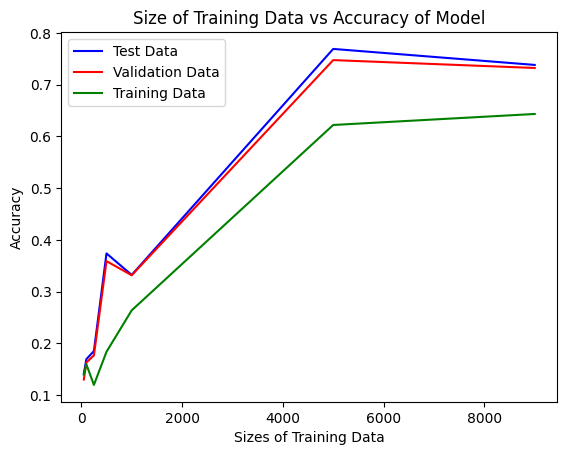

In [47]:
training_Accuracy_values = []
for history in training_Accuracy:
    training_Accuracy_values.append(history.history["accuracy"][9])
graph_accuracy(training_set_size, testing_Accuracy, validation_Accuracy, training_Accuracy_values)